In [1]:
%matplotlib inline


# Blitting tutorial


'Blitting' is a `standard technique
<https://en.wikipedia.org/wiki/Bit_blit>`__ in raster graphics that,
in the context of Matplotlib, can be used to (drastically) improve
performance of interactive figures. For example, the
:mod:`~.animation` and :mod:`~.widgets` modules use blitting
internally. Here, we demonstrate how to implement your own blitting, outsidae
of these classes.

The source of the performance gains is simply not re-doing work we do
not have to.  If the limits of an Axes have not changed, then there is
no need to re-draw all of the ticks and tick-labels (particularly
because text is one of the more expensive things to render).

The procedure to save our work is roughly:

- draw the figure, but exclude any artists marked as 'animated'
- save a copy of the RBGA buffer

In the future, to update the 'animated' artists we

- restore our copy of the RGBA buffer
- redraw only the animated artists
- show the resulting image on the screen

thus saving us from having to re-draw everything which is _not_
animated.  One consequence of this procedure is that your animated
artists are always drawn at a higher z-order than the static artists.

Not all backends support blitting.  You can check if a given canvas does via
the `.FigureCanvasBase.supports_blit` property.

<div class="alert alert-danger"><h4>Warning</h4><p>This code does not work with the OSX backend (but does work with other
   GUI backends on mac).</p></div>

Minimal example
---------------

We can use the `.FigureCanvasAgg` methods
`~.FigureCanvasAgg.copy_from_bbox` and
`~.FigureCanvasAgg.restore_region` in conjunction with setting
``animated=True`` on our artist to implement a minimal example that
uses blitting to accelerate rendering


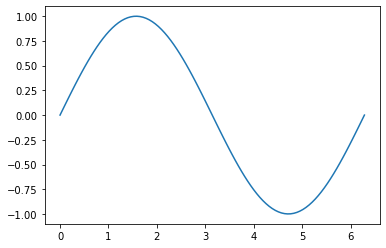

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)

fig, ax = plt.subplots()

# animated=True tells matplotlib to only draw the artist when we
# explicitly request it
(ln,) = ax.plot(x, np.sin(x), animated=True)

# make sure the window is raised, but the script keeps going
plt.show(block=False)

# stop to admire our empty window axes and ensure it is rendered at
# least once.
#
# We need to fully draw the figure at its final size on the screen
# before we continue on so that :
#  a) we have the correctly sized and drawn background to grab
#  b) we have a cached renderer so that ``ax.draw_artist`` works
# so we spin the event loop to let the backend process any pending operations
plt.pause(0.1)

# get copy of entire figure (everything inside fig.bbox) sans animated artist
bg = fig.canvas.copy_from_bbox(fig.bbox)
# draw the animated artist, this uses a cached renderer
ax.draw_artist(ln)
# show the result to the screen, this pushes the updated RGBA buffer from the
# renderer to the GUI framework so you can see it
fig.canvas.blit(fig.bbox)

for j in range(100):
    # reset the background back in the canvas state, screen unchanged
    fig.canvas.restore_region(bg)
    # update the artist, neither the canvas state nor the screen have changed
    ln.set_ydata(np.sin(x + (j / 100) * np.pi))
    # re-render the artist, updating the canvas state, but not the screen
    ax.draw_artist(ln)
    # copy the image to the GUI state, but screen might not changed yet
    fig.canvas.blit(fig.bbox)
    # flush any pending GUI events, re-painting the screen if needed
    fig.canvas.flush_events()
    # you can put a pause in if you want to slow things down
    plt.pause(.1)

This example works and shows a simple animation, however because we
are only grabbing the background once, if the size of the figure in
pixels changes (due to either the size or dpi of the figure
changing) , the background will be invalid and result in incorrect
(but sometimes cool looking!) images.  There is also a global
variable and a fair amount of boiler plate which suggests we should
wrap this in a class.

Class-based example
-------------------

We can use a class to encapsulate the boilerplate logic and state of
restoring the background, drawing the artists, and then blitting the
result to the screen.  Additionally, we can use the ``'draw_event'``
callback to capture a new background whenever a full re-draw
happens to handle resizes correctly.



In [3]:
class BlitManager:
    def __init__(self, canvas, animated_artists=()):
        """
        Parameters
        ----------
        canvas : FigureCanvasAgg
            The canvas to work with, this only works for sub-classes of the Agg
            canvas which have the `~FigureCanvasAgg.copy_from_bbox` and
            `~FigureCanvasAgg.restore_region` methods.

        animated_artists : Iterable[Artist]
            List of the artists to manage
        """
        self.canvas = canvas
        self._bg = None
        self._artists = []

        for a in animated_artists:
            self.add_artist(a)
        # grab the background on every draw
        self.cid = canvas.mpl_connect("draw_event", self.on_draw)

    def on_draw(self, event):
        """Callback to register with 'draw_event'."""
        cv = self.canvas
        if event is not None:
            if event.canvas != cv:
                raise RuntimeError
        self._bg = cv.copy_from_bbox(cv.figure.bbox)
        self._draw_animated()

    def add_artist(self, art):
        """
        Add an artist to be managed.

        Parameters
        ----------
        art : Artist

            The artist to be added.  Will be set to 'animated' (just
            to be safe).  *art* must be in the figure associated with
            the canvas this class is managing.

        """
        if art.figure != self.canvas.figure:
            raise RuntimeError
        art.set_animated(True)
        self._artists.append(art)

    def _draw_animated(self):
        """Draw all of the animated artists."""
        fig = self.canvas.figure
        for a in self._artists:
            fig.draw_artist(a)

    def update(self):
        """Update the screen with animated artists."""
        cv = self.canvas
        fig = cv.figure
        # paranoia in case we missed the draw event,
        if self._bg is None:
            self.on_draw(None)
        else:
            # restore the background
            cv.restore_region(self._bg)
            # draw all of the animated artists
            self._draw_animated()
            # update the GUI state
            cv.blit(fig.bbox)
        # let the GUI event loop process anything it has to do
        cv.flush_events()

Here is how we would use our class.  This is a slightly more complicated
example than the first case as we add a text frame counter as well.



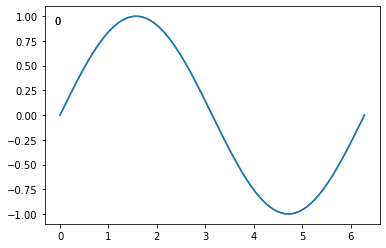

In [8]:
# make a new figure
fig, ax = plt.subplots()
# add a line
(ln,) = ax.plot(x, np.sin(x), animated=True)
# add a frame number
fr_number = ax.annotate(
    "0",
    (0, 1),
    xycoords="axes fraction",
    xytext=(10, -10),
    textcoords="offset points",
    ha="left",
    va="top",
    animated=True,
)
bm = BlitManager(fig.canvas, [ln, fr_number])
# make sure our window is on the screen and drawn
plt.show(block=False)
plt.pause(.1)

for j in range(100):
    # update the artists
    ln.set_ydata(np.sin(x + (j / 100) * np.pi))
    fr_number.set_text("frame: {j}".format(j=j))
    # tell the blitting manager to do it's thing
    bm.update()

This class does not depend on `.pyplot` and is suitable to embed
into larger GUI application.

